<a href="https://colab.research.google.com/github/iamsoura005/Fake-news-detection/blob/main/Fake%20news%20detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import string
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Natural Language Processing libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

In [3]:
# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

In [4]:
# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [5]:
def create_sample_dataset():
    """Create a sample dataset for demonstration"""
    fake_news = [
        "BREAKING: Scientists discover aliens living among us, government covers up truth!",
        "Miracle cure for all diseases found in common household item, doctors hate this trick!",
        "SHOCKING: Celebrity caught in massive scandal, career over forever!",
        "New study proves chocolate cures cancer, eat as much as you want!",
        "Government plans to control your mind through 5G towers, protect yourself now!",
        "Breaking news: President makes controversial statement about economy",
        "Local man discovers fountain of youth in backyard, age reversal possible!",
        "URGENT: Stock market crash imminent, sell everything immediately!",
        "Scientists hate him! Local man discovers one weird trick for weight loss!",
        "EXCLUSIVE: Secret documents reveal government conspiracy against citizens!"
    ]

    real_news = [
        "The Federal Reserve announced a 0.25% interest rate increase following economic indicators.",
        "Research published in Nature shows promising results for new alzheimer's treatment.",
        "Local university receives $5 million grant for renewable energy research project.",
        "City council approves new infrastructure budget for road improvements next year.",
        "Weather service issues tornado watch for three counties in the region.",
        "Stock market closes higher as technology sector shows strong quarterly earnings.",
        "New archaeological discovery sheds light on ancient civilization in the region.",
        "Public health officials recommend updated vaccination schedule for children.",
        "Environmental protection agency announces new clean water regulations for industry.",
        "University study examines impact of remote work on employee productivity."
    ]

    # Combine data
    texts = fake_news + real_news
    labels = [1] * len(fake_news) + [0] * len(real_news)  # 1 = Fake, 0 = Real

    return pd.DataFrame({'text': texts, 'label': labels})

# For real hackathon, use this code to load actual dataset:
# df = pd.read_csv('your_dataset.csv')

# Create and load sample dataset
df = create_sample_dataset()

print("📊 Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst few rows:")
print(df.head())

# Dataset statistics
print(f"\n📈 Dataset Statistics:")
print(f"Total articles: {len(df)}")
print(f"Fake news: {df[df['label'] == 1].shape[0]}")
print(f"Real news: {df[df['label'] == 0].shape[0]}")

📊 Dataset loaded successfully!
Dataset shape: (20, 2)
Columns: ['text', 'label']

First few rows:
                                                text  label
0  BREAKING: Scientists discover aliens living am...      1
1  Miracle cure for all diseases found in common ...      1
2  SHOCKING: Celebrity caught in massive scandal,...      1
3  New study proves chocolate cures cancer, eat a...      1
4  Government plans to control your mind through ...      1

📈 Dataset Statistics:
Total articles: 20
Fake news: 10
Real news: 10


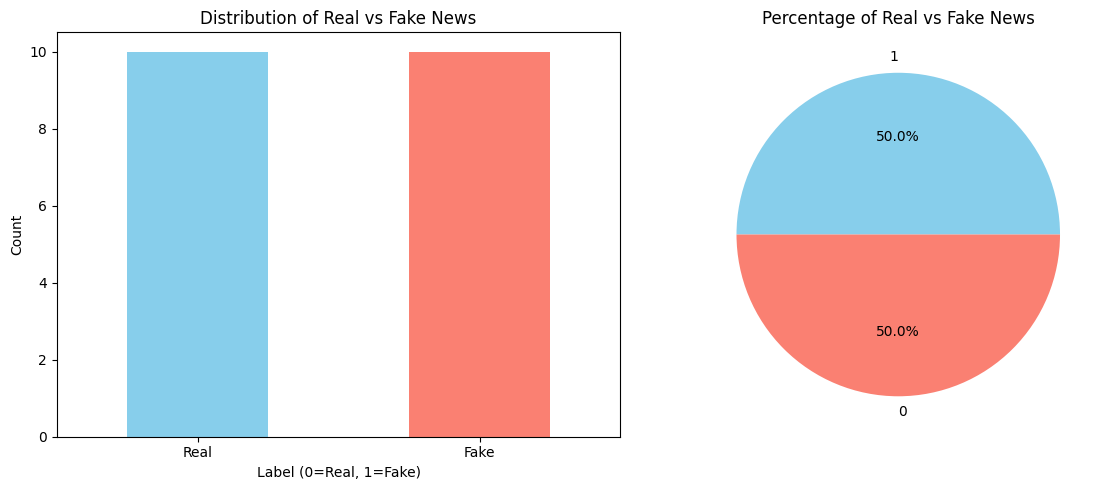

In [6]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df['label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Real vs Fake News')
plt.xlabel('Label (0=Real, 1=Fake)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Real', 'Fake'], rotation=0)

plt.subplot(1, 2, 2)
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'salmon'])
plt.title('Percentage of Real vs Fake News')
plt.ylabel('')

plt.tight_layout()
plt.show()

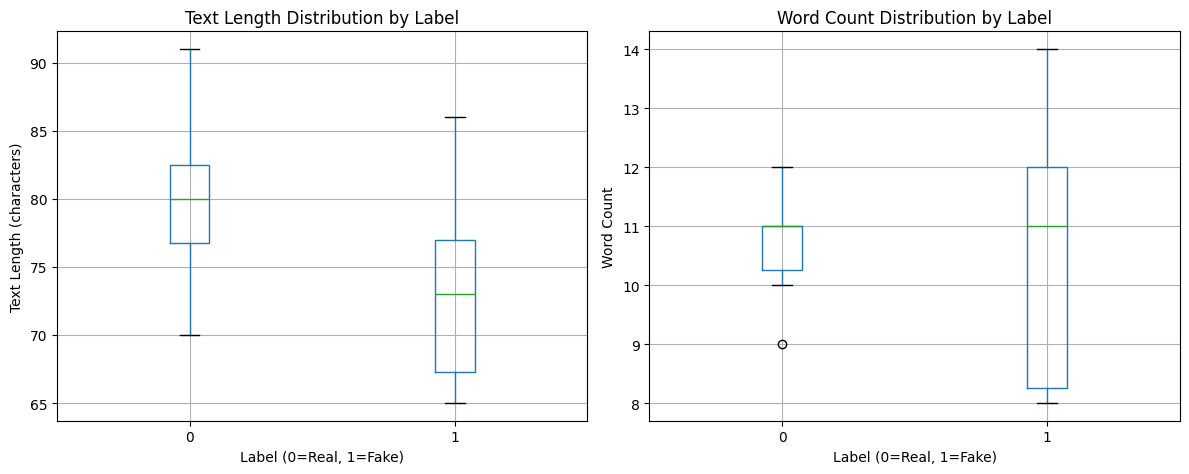

📊 Exploratory Data Analysis completed!


In [7]:
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df.boxplot(column='text_length', by='label', ax=plt.gca())
plt.title('Text Length Distribution by Label')
plt.suptitle('')
plt.xlabel('Label (0=Real, 1=Fake)')
plt.ylabel('Text Length (characters)')

plt.subplot(1, 2, 2)
df.boxplot(column='word_count', by='label', ax=plt.gca())
plt.title('Word Count Distribution by Label')
plt.suptitle('')
plt.xlabel('Label (0=Real, 1=Fake)')
plt.ylabel('Word Count')

plt.tight_layout()
plt.show()

print("📊 Exploratory Data Analysis completed!")

In [8]:
class TextPreprocessor:
    def __init__(self):
        self.stemmer = PorterStemmer()
        self.stop_words = set(stopwords.words('english'))

    def clean_text(self, text):
        """Clean and preprocess text"""
        # Convert to lowercase
        text = text.lower()

        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

        # Remove user mentions and hashtags
        text = re.sub(r'@\w+|#\w+', '', text)

        # Remove punctuation and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Remove extra whitespace
        text = ' '.join(text.split())

        return text

    def tokenize_and_stem(self, text):
        """Tokenize and stem text"""
        # Tokenize
        tokens = word_tokenize(text)

        # Remove stopwords and stem
        tokens = [self.stemmer.stem(token) for token in tokens
                 if token not in self.stop_words and len(token) > 2]

        return ' '.join(tokens)

    def preprocess(self, text):
        """Complete preprocessing pipeline"""
        text = self.clean_text(text)
        text = self.tokenize_and_stem(text)
        return text

# Initialize preprocessor
preprocessor = TextPreprocessor()

# Apply preprocessing
print("🔄 Preprocessing text data...")
df['cleaned_text'] = df['text'].apply(preprocessor.preprocess)

print("✅ Text preprocessing completed!")
print("\nExample of preprocessing:")
print(f"Original: {df['text'].iloc[0]}")
print(f"Cleaned: {df['cleaned_text'].iloc[0]}")

🔄 Preprocessing text data...
✅ Text preprocessing completed!

Example of preprocessing:
Original: BREAKING: Scientists discover aliens living among us, government covers up truth!
Cleaned: break scientist discov alien live among govern cover truth


In [9]:
# Split the data
X = df['cleaned_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"📚 Data split completed!")
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(
    max_features=5000,  # Top 5000 features
    ngram_range=(1, 2),  # Unigrams and bigrams
    min_df=2,  # Minimum document frequency
    max_df=0.95  # Maximum document frequency
)

print("🔄 Converting text to numerical features...")
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"✅ Feature extraction completed!")
print(f"Feature matrix shape: {X_train_tfidf.shape}")

📚 Data split completed!
Training set size: 16
Test set size: 4
🔄 Converting text to numerical features...
✅ Feature extraction completed!
Feature matrix shape: (16, 18)


In [10]:
# Define multiple models to compare
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Train and evaluate models
results = {}

print("🤖 Training machine learning models...")
print("=" * 50)

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train model
    model.fit(X_train_tfidf, y_train)

    # Make predictions
    y_pred = model.predict(X_test_tfidf)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

    print(f"✅ {name} Accuracy: {accuracy:.4f}")

    # Detailed classification report
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))
    print("-" * 50)

🤖 Training machine learning models...

Training Logistic Regression...
✅ Logistic Regression Accuracy: 0.7500

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

        Real       0.67      1.00      0.80         2
        Fake       1.00      0.50      0.67         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4

--------------------------------------------------

Training Naive Bayes...
✅ Naive Bayes Accuracy: 0.7500

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

        Real       0.67      1.00      0.80         2
        Fake       1.00      0.50      0.67         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4

-----------------------------------------

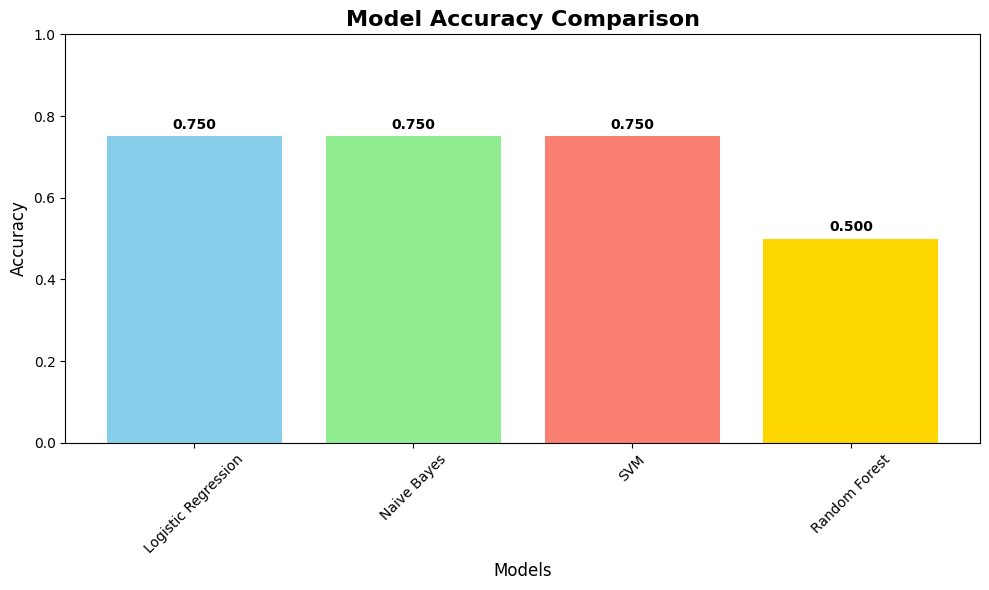

In [11]:
plt.figure(figsize=(10, 6))
models_names = list(results.keys())
accuracies = list(results.values())

bars = plt.bar(models_names, accuracies, color=['skyblue', 'lightgreen', 'salmon', 'gold'])
plt.title('Model Accuracy Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


 Best Model: Logistic Regression
Best Accuracy: 0.7500


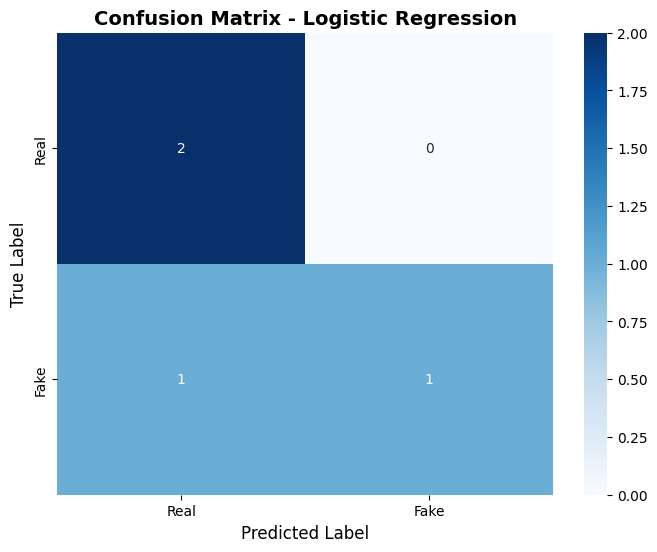

In [12]:
best_model_name = max(results, key=results.get)
best_accuracy = results[best_model_name]

print(f" Best Model: {best_model_name}")
print(f"Best Accuracy: {best_accuracy:.4f}")

# =============================================================================
# STEP 8: CONFUSION MATRIX FOR BEST MODEL
# =============================================================================

# Get best model
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test_tfidf)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

In [13]:
# STEP 9: PREDICTION FUNCTION
def predict_news(text, model=best_model, vectorizer=vectorizer, preprocessor=preprocessor):
    """
    Predict if a news article is fake or real

    Args:
        text (str): News article text
        model: Trained ML model
        vectorizer: Fitted TF-IDF vectorizer
        preprocessor: Text preprocessor

    Returns:
        dict: Prediction result with probability
    """
    # Preprocess text
    cleaned_text = preprocessor.preprocess(text)

    # Convert to TF-IDF features
    text_tfidf = vectorizer.transform([cleaned_text])

    # Make prediction
    prediction = model.predict(text_tfidf)[0]

    # Get prediction probability (if available)
    if hasattr(model, 'predict_proba'):
        proba = model.predict_proba(text_tfidf)[0]
        confidence = max(proba)
    else:
        confidence = "Not available"

    result = {
        'prediction': 'Fake' if prediction == 1 else 'Real',
        'confidence': confidence,
        'label': prediction
    }

    return result


In [14]:
print("\n" + "="*60)
print("🧪 TESTING THE MODEL WITH SAMPLE NEWS")
print("="*60)

# Test examples
test_examples = [
    "Scientists at Harvard University published a peer-reviewed study showing the benefits of regular exercise.",
    "BREAKING: Aliens landed in New York City yesterday, government hiding the truth!",
    "The stock market experienced volatility following the Federal Reserve's latest announcement.",
    "This one weird trick will make you rich overnight, doctors hate it!"
]

for i, example in enumerate(test_examples, 1):
    print(f"\n📰 Test Example {i}:")
    print(f"Text: {example}")

    result = predict_news(example)
    print(f"Prediction: {result['prediction']}")
    if result['confidence'] != "Not available":
        print(f"Confidence: {result['confidence']:.4f}")
    print("-" * 40)


🧪 TESTING THE MODEL WITH SAMPLE NEWS

📰 Test Example 1:
Text: Scientists at Harvard University published a peer-reviewed study showing the benefits of regular exercise.
Prediction: Real
Confidence: 0.6006
----------------------------------------

📰 Test Example 2:
Text: BREAKING: Aliens landed in New York City yesterday, government hiding the truth!
Prediction: Fake
Confidence: 0.6363
----------------------------------------

📰 Test Example 3:
Text: The stock market experienced volatility following the Federal Reserve's latest announcement.
Prediction: Real
Confidence: 0.5757
----------------------------------------

📰 Test Example 4:
Text: This one weird trick will make you rich overnight, doctors hate it!
Prediction: Fake
Confidence: 0.5996
----------------------------------------
